In [61]:
import numpy as np 
import random 
import matplotlib.pyplot as plt

In [6]:
def generate_sumplete_instance(k, deletion_rate=1/3,min_num=1,max_num=10):
    
    matrix = np.random.randint(min_num, max_num, (k, k))

    flat_matrix = matrix.flatten()
    num_deletions = int(len(flat_matrix) * deletion_rate)
    indexes_to_delete = random.sample(range(len(flat_matrix)), num_deletions)
    for index in indexes_to_delete:
        flat_matrix[index] = 0  

    # calculating the sums after delettion
    deleted_matrix = flat_matrix.reshape(k, k)
    target_row_sums = np.sum(deleted_matrix, axis=1)
    target_col_sums = np.sum(deleted_matrix, axis=0)
    
    # random values for deleted numbers
    for i in range(len(deleted_matrix)):
        for j in range(len(deleted_matrix[0])):
            if deleted_matrix[i][j] == 0:
                deleted_matrix[i][j] = np.random.randint(min_num,max_num)
    

    return deleted_matrix, target_row_sums, target_col_sums

######################################################
k = 6  
instance, row_sums, col_sums = generate_sumplete_instance(k)
print( instance)
print("target rows" ,row_sums)
print("target_cols", col_sums)


[[5 4 1 4 8 7]
 [9 3 5 5 9 7]
 [2 2 6 5 3 7]
 [9 2 5 3 7 1]
 [5 7 2 2 6 4]
 [9 6 9 1 1 8]]
target rows [21 28 19 26  7 18]
target_cols [30 11 17 12 20 29]


In [47]:
########### FITNESS FUNCITONS #############
    
def fitness_part_b(self,chromosome): # Fitness is higher when the sum difference is lower
    current_row_sums = np.sum(chromosome * self.instance, axis=1)
    current_col_sums = np.sum(chromosome * self.instance, axis=0)
    row_diff = np.sum(np.abs(self.target_row_sums - current_row_sums))
    col_diff = np.sum(np.abs(self.target_col_sums - current_col_sums))
    return 1 / (1 + row_diff + col_diff)  

def fitness_part_a(self,chromosome): # 1 for correct and 0 for all others
    
    current_row_sums = np.sum(chromosome * self.instance, axis=1)
    current_col_sums = np.sum(chromosome * self.instance, axis=0)
    if np.array_equal(current_row_sums, self.target_row_sums) and np.array_equal(current_col_sums, self.target_col_sums):
        return 1
    else:
        return 0


In [8]:
########### SELECTION FUNCTIONS ##################

def tournament_selection(self, tournament_size):
       
        selected_parents = []
        for _ in range(len(self.population)):
            # Randomly select tournament participants
            participants = random.sample(self.population, tournament_size)
            # Evaluate the fitness of tournament participants
            participant_fitnesses = [self.calculate_fitness(individual) for individual in participants]
            # Select the best individual from participants
            winner_index = np.argmax(participant_fitnesses)
            selected_parents.append(participants[winner_index])
        
        return selected_parents

def practical_roulette_selection(population, fitness_scores):
    average_fitness = np.mean(fitness_scores)
    new_population = []
    
    for i, individual in enumerate(population):
        fitness = fitness_scores[i]
        
        if fitness == average_fitness:
            # The individual survives
            new_population.append(individual)
        elif fitness < average_fitness:
            # The individual survives with a probability of f_i / f̄
            if random.random() < (fitness / average_fitness):
                new_population.append(individual)
        else:
            # The individual produces floor(f_i / f̄) offspring
            offspring_count = int(fitness // average_fitness)
            new_population.extend([individual] * offspring_count)
            
            # The individual has a chance to produce one more offspring
            if random.random() < (fitness / average_fitness - offspring_count):
                new_population.append(individual)
    
    return new_population

In [9]:
####################### CROSSOVER METHODS #############################
def single_point_crossover(parent1, parent2, p_c):
    # Only perform crossover with probability p_c
    if np.random.rand() < p_c:
        # Choose a random crossover point
        crossover_point = np.random.randint(1, len(parent1))  # start from 1 to avoid null crossover
        # Create children by combining the parents at the crossover point
        child1 = np.vstack((parent1[:crossover_point, :], parent2[crossover_point:, :]))
        child2 = np.vstack((parent2[:crossover_point, :], parent1[crossover_point:, :]))
    else:
        # With probability 1 - p_c, copy the parents
        child1, child2 = np.copy(parent1), np.copy(parent2)

    return child1, child2

In [10]:
####################### MUTATION FUNCTIONS ####################
def mutate_bit_flip(chromosome, mutation_rate):
    mutation_matrix = np.random.rand(len(chromosome),len(chromosome)) < mutation_rate
    # XOR with mutation matrix will flip the bits where mutation_matrix is True
    chromosome = np.logical_xor(chromosome, mutation_matrix).astype(int)
    return chromosome

# previously used mutation function
# def mutate_random_resetting(chromosome, mutation_rate):
#     for i in range(len(chromosome)):
#         for j in range(self.k):
#             if np.random.rand() < mutation_rate:
#                 chromosome[i, j] = 1 if chromosome[i, j] == 0 else 0
#     return chromosome


In [139]:
########################### OPTIMALITY VERIFICATION ##################

def verify_solution(instance, solution, target_row_sums, target_col_sums):
    
    if solution is None:
        return(None,None,False)
    
    # Pretty Printing the instance
    max_num_width = 2
    separator = '-' * (instance.shape[1] * (max_num_width + 1) + 3)
    
    # Print the matrix with row sums
    for i, row in enumerate(instance):
        # Print the matrix row with proper formatting
        print(' '.join(f"{num:>{max_num_width}}" for num in row) + ' | ' + str(target_row_sums[i]))
 
    print(separator)
    # Print the column sums
    print(' '.join(f"{num:>{max_num_width}}" for num in target_col_sums) + ' |') 

    print('\n')
    
    
    # Calculate the sum of the rows and columns in the solution
    solution_row_sums = np.sum(solution * instance, axis=1)
    print("Solution Row Sums after deletion",solution_row_sums)
    solution_col_sums = np.sum(solution * instance, axis=0)
    print("Solution Column Sums after deletion",solution_col_sums)
    

    # Check if the calculated sums match the target sums
    is_row_correct = np.array_equal(solution_row_sums, target_row_sums)
    is_col_correct = np.array_equal(solution_col_sums, target_col_sums)

    # The solution is optimal if both row and column sums match the target sums
    print("is the solution optimal?? :",is_row_correct and is_col_correct)
    return (target_row_sums-solution_row_sums,target_col_sums-solution_col_sums,is_row_correct and is_col_correct)


In [135]:
################### GENETIC ALGORITHM SOLVER ###################

class GA:
    
    def __init__(self,population_size,instance,target_row_sums,target_col_sums,p_c,p_m, generations):
        self.k = len(instance)
        self.instance = instance
        self.target_row_sums = target_row_sums
        self.target_col_sums = target_col_sums
        self.population = self.generate_initial_population(population_size,self.k)
        self.generations = generations
        self.p_c = p_c
        self.p_m = p_m
        self.elitism_size = 10
        
        self.best_generation = None
    
    def generate_initial_population(self,population_size, k):
        population = []
        for _ in range(population_size):
            chromosome = np.random.choice([0, 1], (k, k))
            population.append(chromosome)
        return population
    
    def calculate_fitness(self,chromosome): # Fitness is higher when the sum difference is lower
        return fitness_part_b(self, chromosome)
    
    def select_parents(self,population, fitness_scores):
        return self.tournament_selection()

    def tournament_selection(self, tournament_size=3):
        
        selected_parents = []
        for _ in range(len(self.population)):
            # Randomly select tournament participants
            participants = random.sample(self.population, tournament_size)
            # Evaluate the fitness of tournament participants
            participant_fitnesses = [self.calculate_fitness(individual) for individual in participants]
            # Select the best individual from participants
            winner_index = np.argmax(participant_fitnesses)
            selected_parents.append(participants[winner_index])
        
        return selected_parents

    def crossover(self,parent1, parent2):
        return single_point_crossover(parent1, parent2, self.p_c)

    def mutate(self, chromosome): ### _bit_flip
        mutation_matrix = np.random.rand(self.k, self.k) < self.p_m
        
        chromosome = np.logical_xor(chromosome, mutation_matrix).astype(int)
        return chromosome
    
    def get_elite_group(self,fitness_values):
        sorted_population = [x for _,x in sorted(zip(fitness_values,self.population),key=lambda pair:pair[0], reverse=True)]
        
        return sorted_population[:self.elitism_size]


    def solve(self):
        best_solution = None
        best_fitness = 0

        for generation in range(self.generations):
            fitness_scores = [self.calculate_fitness(chromosome) for chromosome in self.population]
            
            # Check for the best solution
            current_best = max(fitness_scores)
            if current_best > best_fitness:
                best_fitness = current_best
                best_solution = self.population[np.argmax(fitness_scores)]

            if best_fitness == 1:  
                self.best_generation = generation
                break
            
            # Selection
            parents = self.select_parents(self.population, fitness_scores)
            # print("number of parents", len(parents))
            
            # Crossover and mutation
            # new_population = []
            new_population = self.get_elite_group(fitness_scores)
            
            for _ in range(len(parents) // 2):
                parent1, parent2 = random.sample(parents, 2)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.extend([child1, child2])
            
            self.population = new_population[:len(self.population)]
            
            
        self.best_generation = generation
        return best_solution

# DRIVER CODE 
k = 5 # Dimension of the matrix
population_size = 100
generations = 1000
mutation_rate = 0.01
crossover_rate = 0.7
instance, row_sums, col_sums = generate_sumplete_instance(k)
algorithm = GA(population_size,instance,row_sums,col_sums,crossover_rate,mutation_rate,generations)
solution = algorithm.solve()


### Part A

In [94]:
population_size = 100
generations = 1000
mutation_rate = 0.01
crossover_rate = 0.7
number_of_convergence = {}
average_generations = {}
# Measuring the number of optimal solutions generated for different size problems
for k in range(3,7):
    number_of_convergence[k] = 0
    best_generations = []
    for _ in range(10):
        instance, row_sums, col_sums = generate_sumplete_instance(k)
        algorithm = GA(population_size,instance,row_sums,col_sums,crossover_rate,mutation_rate,generations)
        solution = algorithm.solve()
        if verify_solution(instance, solution, row_sums, col_sums)[2]:
            number_of_convergence[k] += 1
        best_generations.append(algorithm.best_generation)
    average_generations[k] = np.mean(best_generations)
        

 1  2  7 | 3
 9  4  5 | 14
 8  7  3 | 15
------------
18  9  5 |


Solution Row Sums after deletion [ 3 14 15]
Solution Column Sums after deletion [18  9  5]
is the solution optimal?? : True
 4  7  1 | 11
 3  2  3 | 2
 9  5  8 | 22
------------
13 14  8 |


Solution Row Sums after deletion [11  2 22]
Solution Column Sums after deletion [13 14  8]
is the solution optimal?? : True
 8  4  8 | 12
 1  8  3 | 4
 2  1  5 | 3
------------
11  5  3 |


Solution Row Sums after deletion [12  4  3]
Solution Column Sums after deletion [11  5  3]
is the solution optimal?? : True
 9  7  5 | 7
 8  2  3 | 10
 3  9  6 | 18
------------
11 18  6 |


Solution Row Sums after deletion [ 7 10 18]
Solution Column Sums after deletion [11 18  6]
is the solution optimal?? : True
 1  3  4 | 3
 3  8  2 | 5
 2  8  5 | 15
------------
 5 11  7 |


Solution Row Sums after deletion [ 3  5 15]
Solution Column Sums after deletion [ 5 11  7]
is the solution optimal?? : True
 1  5  5 | 10
 4  2  1 | 3
 4  7  4 | 11
------

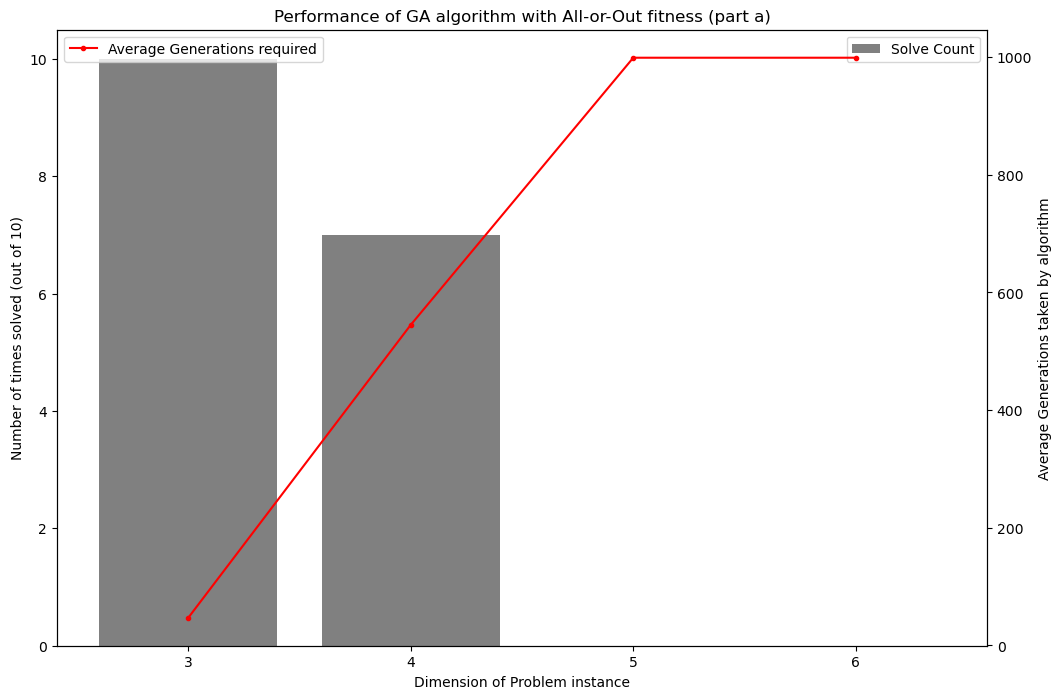

In [121]:
fig, (ax1) = plt.subplots(1,1,figsize=(12,8))

ax1.bar(number_of_convergence.keys(),number_of_convergence.values(),label = 'Solve Count',color='grey')
ax1.set_xlabel("Dimension of Problem instance")
ax1.set_xticks([int(x) for x in number_of_convergence.keys()])
ax1.set_ylabel("Number of times solved (out of 10)")
ax1.legend()
ax1.set_title("Performance of GA algorithm with All-or-Out fitness (part a)")

ax2 = ax1.twinx()
ax2.plot(average_generations.keys(),average_generations.values(), label='Average Generations required',color='r',marker='.')
ax2.set_ylabel("Average Generations taken by algorithm")
ax2.legend()

fig.savefig('part_a.png')


### Part B

In [158]:
population_size = 100
generations = 1000
mutation_rate = 0.1
crossover_rate = 0.8
# number_of_convergence_b = {}
# average_generations_b = {}
# Measuring the number of optimal solutions generated for different size problems
for k in range(6,7):
    number_of_convergence_b[k] = 0
    best_generations = []
    for _ in range(10):
        instance, row_sums, col_sums = generate_sumplete_instance(k)
        algorithm = GA(population_size,instance,row_sums,col_sums,crossover_rate,mutation_rate,generations)
        solution = algorithm.solve()
        if verify_solution(instance, solution, row_sums, col_sums)[2]:
            number_of_convergence_b[k] += 1
        best_generations.append(algorithm.best_generation)
    average_generations_b[k] = np.mean(best_generations)
        

 2  1  4  5  8  6 | 23
 1  3  3  4  6  5 | 16
 4  8  8  4  7  1 | 13
 2  4  7  5  8  2 | 24
 5  2  8  2  7  9 | 31
 7  2  2  8  3  1 | 11
---------------------
10  9 32 22 23 22 |


Solution Row Sums after deletion [23 16 13 24 31 12]
Solution Column Sums after deletion [13  9 32 20 23 22]
is the solution optimal?? : False
 9  7  2  7  3  2 | 19
 6  2  8  8  1  6 | 17
 5  6  5  2  3  4 | 10
 9  7  3  4  1  6 | 24
 9  4  3  9  1  8 | 34
 7  6  8  8  1  9 | 18
---------------------
32 13 22 22 10 23 |


Solution Row Sums after deletion [19 17 10 23 34 17]
Solution Column Sums after deletion [31 13 21 22 10 23]
is the solution optimal?? : False
 6  8  1  9  9  4 | 28
 9  6  3  6  9  1 | 33
 1  1  9  6  7  3 | 12
 2  3  3  1  6  9 | 13
 7  5  3  8  2  7 | 15
 5  9  1  3  4  7 | 22
---------------------
21 27  8 15 31 21 |


Solution Row Sums after deletion [28 33 13 13 12 24]
Solution Column Sums after deletion [22 26  8 16 31 20]
is the solution optimal?? : False
 3  9  9  6  7  9 | 34
 6

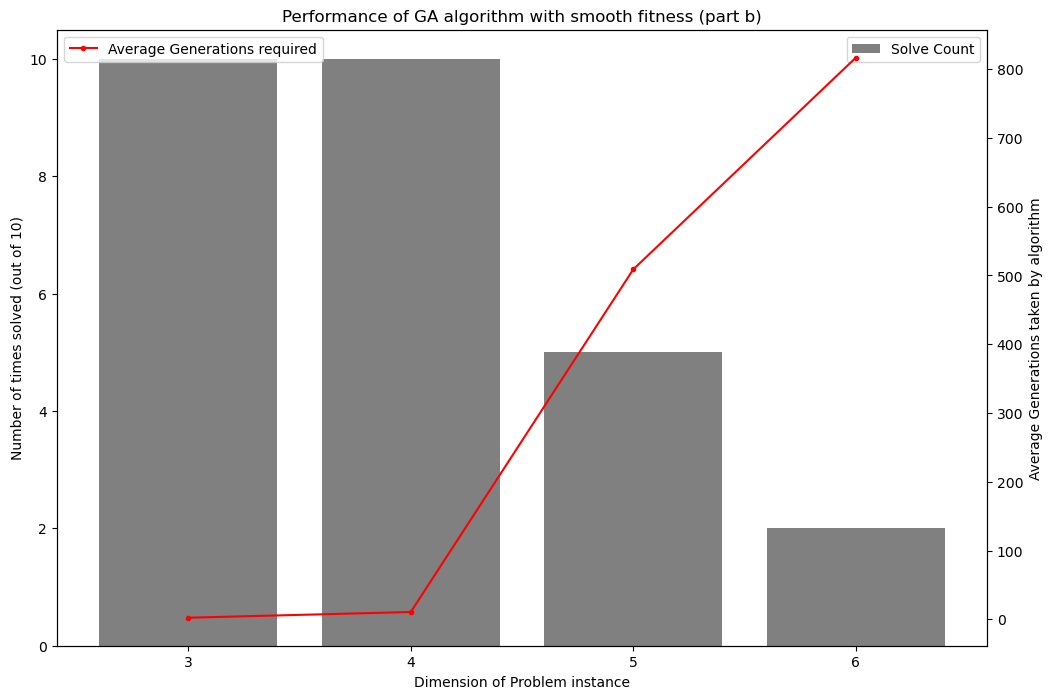

In [159]:
fig2, (ax21) = plt.subplots(1,1,figsize=(12,8))

ax21.bar(number_of_convergence_b.keys(),number_of_convergence_b.values(),label = 'Solve Count',color='grey')
ax21.set_xlabel("Dimension of Problem instance")
ax21.set_xticks([int(x) for x in number_of_convergence_b.keys()])
ax21.set_ylabel("Number of times solved (out of 10)")
ax21.legend()
ax21.set_title("Performance of GA algorithm with smooth fitness (part b)")

ax22 = ax21.twinx()
ax22.plot(average_generations_b.keys(),average_generations_b.values(), label='Average Generations required',color='r',marker='.')
ax22.set_ylabel("Average Generations taken by algorithm")
ax22.legend()

fig2.savefig('part_2b.png')


In [150]:
number_of_convergence_b

{3: 10, 4: 10, 5: 5, 6: 3}

### Part C

In [156]:
k = 4
population_size = 100
generations = 1000
crossover_rate = 0.8
number_of_convergence_m = {}
average_generations_m = {}
# Measuring the number of optimal solutions generated for different parameters
for m in [0.01,0.05,0.1,0.2]:
    number_of_convergence_m[str(m)] = 0
    best_generations = []
    for _ in range(10):
        instance, row_sums, col_sums = generate_sumplete_instance(k)
        algorithm = GA(population_size,instance,row_sums,col_sums,crossover_rate,m,generations)
        solution = algorithm.solve()
        if verify_solution(instance, solution, row_sums, col_sums)[2]:
            number_of_convergence_m[str(m)] += 1
        best_generations.append(algorithm.best_generation)
    average_generations_m[str(m)] = np.mean(best_generations)
        

 2  4  4  4 | 8
 1  9  2  8 | 12
 5  7  2  9 | 14
 8  8  1  9 | 18
---------------
 6 24  9 13 |


Solution Row Sums after deletion [ 8 12 14 18]
Solution Column Sums after deletion [ 6 24  9 13]
is the solution optimal?? : True
 9  9  3  4 | 13
 1  1  7  8 | 16
 1  3  1  6 | 4
 9  5  1  1 | 16
---------------
19  9  8 13 |


Solution Row Sums after deletion [13 16  4 16]
Solution Column Sums after deletion [19  9  8 13]
is the solution optimal?? : True
 5  1  2  5 | 13
 8  7  9  1 | 1
 8  4  8  1 | 9
 1  4  6  5 | 16
---------------
 6  5 16 12 |


Solution Row Sums after deletion [13  1  9 16]
Solution Column Sums after deletion [ 6  5 16 12]
is the solution optimal?? : True
 1  7  9  1 | 9
 5  9  3  6 | 17
 8  2  8  2 | 12
 8  3  1  6 | 9
---------------
 6 21 11  9 |


Solution Row Sums after deletion [ 8 18 12 11]
Solution Column Sums after deletion [ 8 21 11  9]
is the solution optimal?? : False
 1  8  7  1 | 1
 9  6  6  3 | 24
 9  1  2  4 | 7
 7  8  6  5 | 19
---------------
 9 

In [157]:
number_of_convergence_m

{'0.01': 9, '0.05': 10, '0.1': 10, '0.2': 10}

In [154]:
k = 4
population_size = 100
generations = 1000
mutation_rate = 0.01
number_of_convergence_c = {}
average_generations_c = {}
# Measuring the number of optimal solutions generated for different parameters
for c in [0.5,0.6,0.7,0.8,0.9]:
    number_of_convergence_c[c] = 0
    best_generations = []
    for _ in range(10):
        instance, row_sums, col_sums = generate_sumplete_instance(k)
        algorithm = GA(population_size,instance,row_sums,col_sums,c,mutation_rate,generations)
        solution = algorithm.solve()
        if verify_solution(instance, solution, row_sums, col_sums)[2]:
            number_of_convergence_c[c] += 1
        best_generations.append(algorithm.best_generation)
    average_generations_c[c] = np.mean(best_generations)

 4  7  7  5 | 23
 6  9  6  3 | 6
 6  5  4  5 | 14
 3  5  1  5 | 9
---------------
13 12 12 15 |


Solution Row Sums after deletion [23  6 14  9]
Solution Column Sums after deletion [13 12 12 15]
is the solution optimal?? : True
 3  4  7  9 | 19
 7  5  4  6 | 22
 8  3  3  7 | 11
 8  6  4  3 | 10
---------------
18 11 18 15 |


Solution Row Sums after deletion [19 22 11 10]
Solution Column Sums after deletion [18 11 18 15]
is the solution optimal?? : True
 8  3  7  1 | 7
 7  6  6  6 | 19
 9  7  5  1 | 21
 8  3  9  7 | 27
---------------
24 16 27  7 |


Solution Row Sums after deletion [ 7 19 21 27]
Solution Column Sums after deletion [24 16 27  7]
is the solution optimal?? : True
 1  7  8  7 | 9
 9  4  9  2 | 24
 2  4  5  3 | 14
 4  2  3  5 | 5
---------------
12  8 22 10 |


Solution Row Sums after deletion [ 9 24 14  5]
Solution Column Sums after deletion [12  8 22 10]
is the solution optimal?? : True
 6  7  1  9 | 16
 6  4  3  9 | 16
 6  5  6  8 | 11
 7  8  7  6 | 22
---------------
1

In [155]:
number_of_convergence_c

{5: 7, 6: 8, 7: 8, 8: 10, 9: 9}

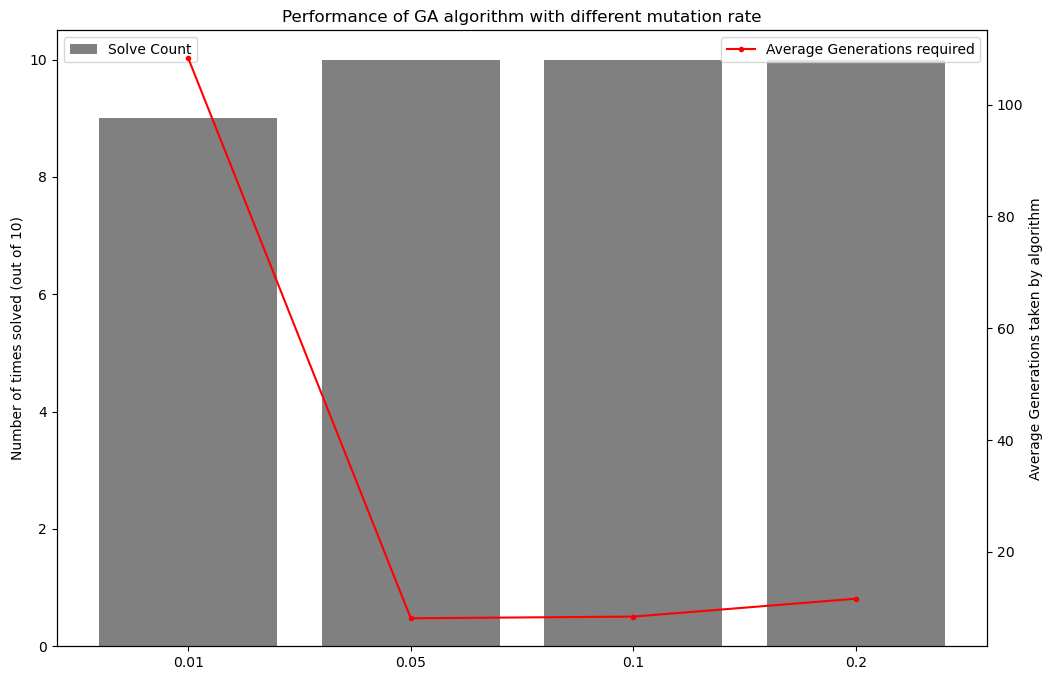

In [164]:
fig3, (ax31) = plt.subplots(1,1,figsize=(12,8))

ax31.bar(number_of_convergence_m.keys(),number_of_convergence_m.values(),label = 'Solve Count',color='grey')
ax31.set_xlabel("")
# ax31.set_xticks([int(x) for x in number_of_convergence_b.keys()])
ax31.set_ylabel("Number of times solved (out of 10)")
ax31.legend()
ax31.set_title("Performance of GA algorithm with different mutation rate")

ax32 = ax31.twinx()
ax32.plot(average_generations_m.keys(),average_generations_m.values(), label='Average Generations required',color='r',marker='.')
ax32.set_ylabel("Average Generations taken by algorithm")
ax32.legend()

fig3.savefig('part_2c_a.png')


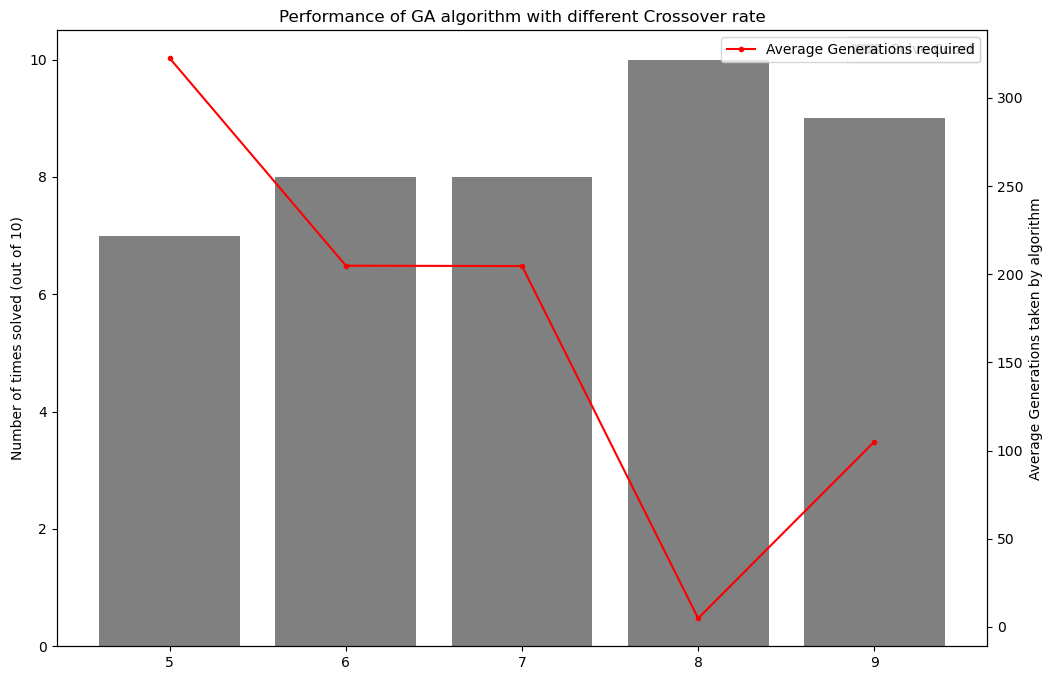

In [166]:
fig4, (ax41) = plt.subplots(1,1,figsize=(12,8))

ax41.bar(number_of_convergence_c.keys(),number_of_convergence_c.values(),label = 'Solve Count',color='grey')
ax41.set_xlabel("")
# ax31.set_xticks([int(x) for x in number_of_convergence_b.keys()])
ax41.set_ylabel("Number of times solved (out of 10)")
ax41.legend()
ax41.set_title("Performance of GA algorithm with different Crossover rate")

ax42 = ax41.twinx()
ax42.plot(average_generations_c.keys(),average_generations_c.values(), label='Average Generations required',color='r',marker='.')
ax42.set_ylabel("Average Generations taken by algorithm")
ax42.legend()

fig4.savefig('part_2c_b.png')